W207: Final Project
===========

Our team (Danish Iqbal, KC Tobin, Jason Vantomme) is working through the Kaggle "House Prices: Advanced Regression Techniques" competition @ https://www.kaggle.com/c/house-prices-advanced-regression-techniques.

Our first step is to scrub the data and generate effective features from what is provided.  We have divided this process into three parts, one for each team member.

In [2]:
# ENVIRONMENT SETUP

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import datetime
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model as lm
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None) 

In [7]:
##
## SETUP JASON (PT 3) DATA ANALYSIS & FEATURE ENGINEERING
##
part3_columns = ['TotRmsAbvGrd', 'Functional', \
                 'Fireplaces', 'FireplaceQu', \
                 'GarageType', 'GarageYrBlt', 'GarageFinish', \
                 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', \
                 'PavedDrive', \
                 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                 'PoolArea', 'PoolQC', 'Fence', \
                 'MiscFeature', 'MiscVal', \
                 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
part3_train_data_cols = original_train_data.loc[:,part3_columns]

print "Full Data Size: " + str(original_train_data.shape)
part3_data = original_train_data[original_train_data.columns[-26:]]
print "Part3 Data Size: " + str(part3_data.shape)


print "Total records = " + str(len(original_train_data))
print ""
print "<< Unique contents sorted >>"
for colname in part3_train_data_cols:
    contents = original_train_data[colname].unique()
    print colname, sorted(contents)
print
print "<< NA's counted >>"
for colname in part3_train_data_cols:
    na_count = original_train_data[colname].isnull().sum()
    print colname, na_count

Full Data Size: (1460, 81)
Part3 Data Size: (1460, 26)
Total records = 1460

<< Unique contents sorted >>
TotRmsAbvGrd [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]
Functional ['Maj1', 'Maj2', 'Min1', 'Min2', 'Mod', 'Sev', 'Typ']
Fireplaces [0, 1, 2, 3]
FireplaceQu [nan, 'Ex', 'Fa', 'Gd', 'Po', 'TA']
GarageType [nan, '2Types', 'Attchd', 'Basment', 'BuiltIn', 'CarPort', 'Detchd']
GarageYrBlt [1915.0, 1920.0, 1930.0, 1931.0, 1935.0, 1939.0, 1945.0, 1948.0, 1953.0, 1954.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1970.0, 1973.0, 1974.0, 1976.0, 1977.0, 1981.0, 1983.0, 1985.0, 1987.0, 1989.0, 1990.0, 1991.0, 1993.0, 1995.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, nan, 1900.0, 1906.0, 1908.0, 1910.0, 1914.0, 1916.0, 1918.0, 1921.0, 1922.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1932.0, 1933.0, 1934.0, 1936.0, 1937.0, 1938.0, 1940.0, 1941.0, 1942.0, 1946.0, 1947.0, 1949.

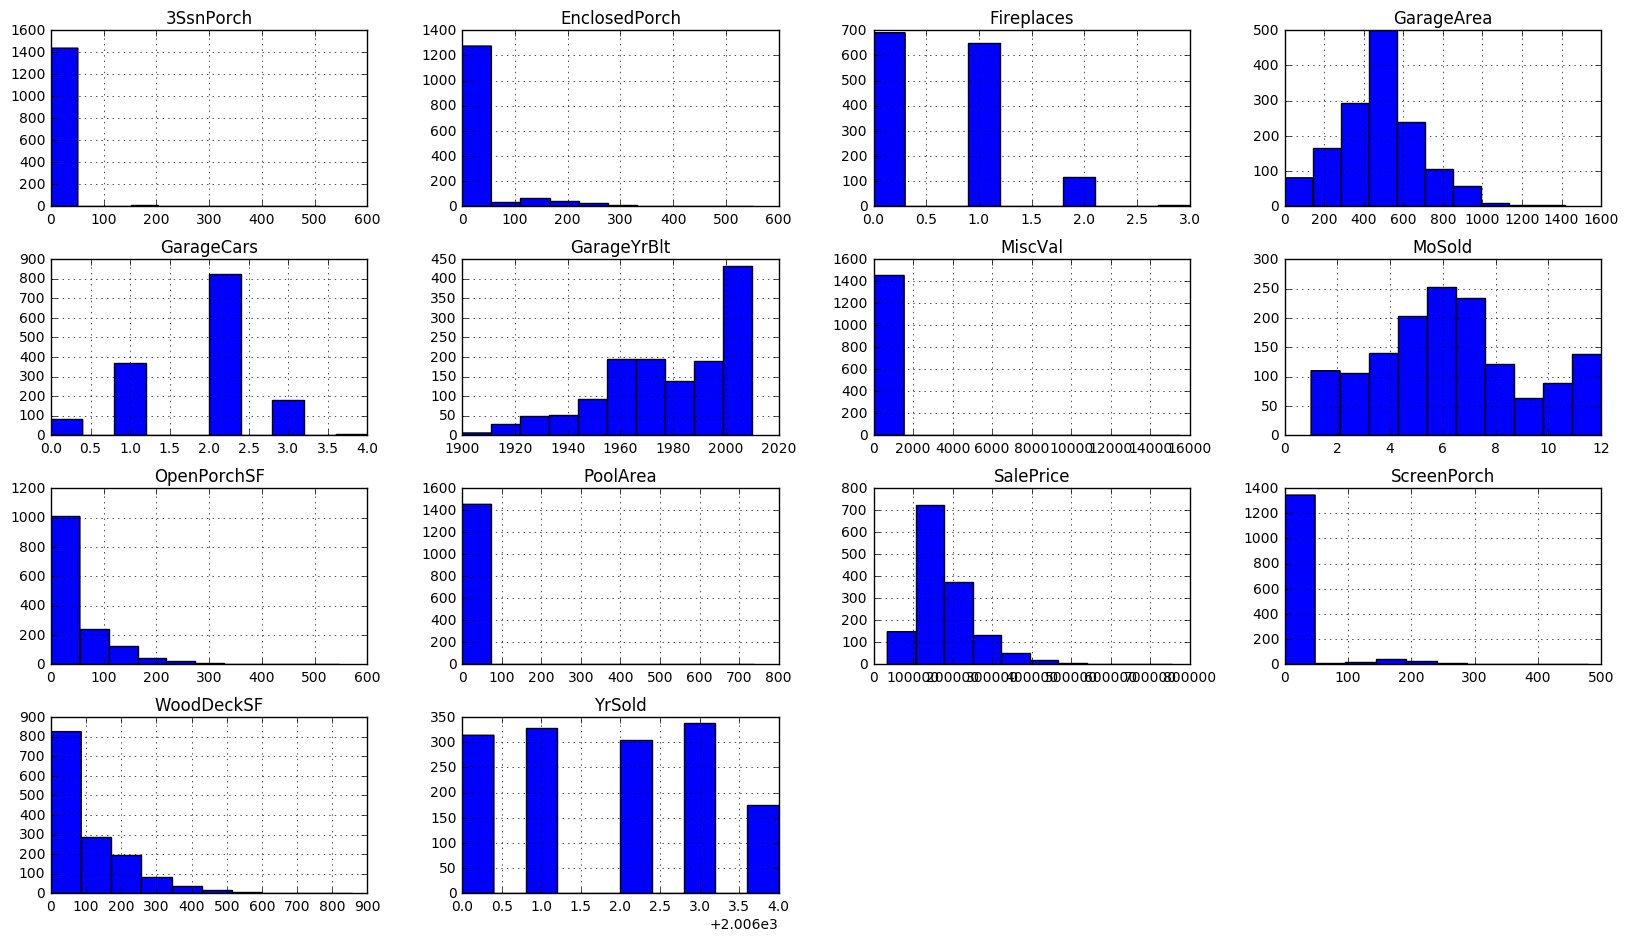

In [10]:
# histograms by feature
part3_data.hist(figsize=(20,20),layout=(7,4));

In [11]:
# plot correlation matrix
corr = part3_data.corr()
print corr

               Fireplaces  GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  \
Fireplaces       1.000000     0.046822    0.300789    0.269141    0.200019   
GarageYrBlt      0.046822     1.000000    0.588920    0.564567    0.224577   
GarageCars       0.300789     0.588920    1.000000    0.882475    0.226342   
GarageArea       0.269141     0.564567    0.882475    1.000000    0.224666   
WoodDeckSF       0.200019     0.224577    0.226342    0.224666    1.000000   
OpenPorchSF      0.169405     0.228425    0.213569    0.241435    0.058661   
EnclosedPorch   -0.024822    -0.297003   -0.151434   -0.121777   -0.125989   
3SsnPorch        0.011257     0.023544    0.035765    0.035087   -0.032771   
ScreenPorch      0.184530    -0.075418    0.050494    0.051412   -0.074181   
PoolArea         0.095074    -0.014501    0.020934    0.061047    0.073378   
MiscVal          0.001409    -0.032417   -0.043080   -0.027400   -0.009551   
MoSold           0.046357     0.005337    0.040522    0.027974  

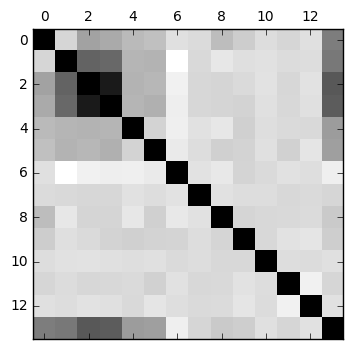

In [12]:
plt.matshow(corr, cmap=plt.cm.Greys)

In [46]:

##
## PART 3 FEATURE ENGINEERING
##

##
## RUN THE TRAINING / ASSESS CYCLE IN A LOOP 'RUNS' TIMES
## IN ORDER TO ASSESS AN AVERAGE IMPROVEMENT
##
runs = 100
total_baseline = 0
total_adjusted = 0

for x in range(0,runs):
    ## ----------------------------
    ## LOAD FRESH 
    ## ----------------------------
    original_train_data = pd.read_csv('data/train.csv',delimiter=',',header=0)
    original_test_data = pd.read_csv('data/test.csv',delimiter=',',header=0)
 
    ## ----------------------------
    ##  BASIC PREPROCESSING 
    ## ----------------------------

    ##
    ## convert categoricals to integers
    ##
    # train data 
    obj_columns = original_train_data.select_dtypes(['object']).columns
    original_train_data.fillna(0, inplace=True)
    original_train_data[obj_columns] = original_train_data[obj_columns].apply(lambda x: x.astype('category').cat.codes)
    # test data
    obj_columns = original_test_data.select_dtypes(['object']).columns
    original_test_data.fillna(0, inplace=True)
    original_test_data[obj_columns] = original_test_data[obj_columns].apply(lambda x: x.astype('category').cat.codes)
    
    ## store the SalePrice as log of original
    original_train_data["SalePrice"] = original_train_data["SalePrice"].apply(np.log)
    
    ## 
    ## flatten categoricals and drop original features
    ##
    enc = OneHotEncoder()
    train_encode = enc.fit_transform(original_train_data.loc[:,["SaleType","SaleCondition", \
                                                                "GarageFinish","GarageType","GarageQual", \
                                                                "GarageCond", "FireplaceQu","PoolQC"]]).toarray()
    print train_encode.shape
    train_encode_df = pd.DataFrame(train_encode)
    original_train_data = pd.concat([original_train_data,train_encode_df],axis=1)
    original_train_data = original_train_data.drop( ["SaleType"], axis=1 )
    original_train_data = original_train_data.drop( ["SaleCondition"], axis=1 )
    original_train_data = original_train_data.drop( ["GarageFinish"], axis=1 )
    original_train_data = original_train_data.drop( ["GarageType"], axis=1 )
    original_train_data = original_train_data.drop( ["GarageQual"], axis=1 )
    original_train_data = original_train_data.drop( ["GarageCond"], axis=1 )
    original_train_data = original_train_data.drop( ["FireplaceQu"], axis=1 )
    original_train_data = original_train_data.drop( ["PoolQC"], axis=1 )
   
    enc = OneHotEncoder()
    test_encode = enc.fit_transform(original_test_data.loc[:,["SaleType","SaleCondition", \
                                                              "GarageFinish","GarageType","GarageQual",\
                                                              "GarageCond", "FireplaceQu","PoolQC"]]).toarray()
    print test_encode.shape
    test_encode_df = pd.DataFrame(test_encode)
    original_test_data = pd.concat([original_test_data,test_encode_df],axis=1)
    original_test_data = original_test_data.drop( ["SaleType"], axis=1 )
    original_test_data = original_test_data.drop( ["SaleCondition"], axis=1 )
    original_test_data = original_test_data.drop( ["GarageFinish"], axis=1 )
    original_test_data = original_test_data.drop( ["GarageType"], axis=1 )
    original_test_data = original_test_data.drop( ["GarageQual"], axis=1 )
    original_test_data = original_test_data.drop( ["GarageCond"], axis=1 )
    original_test_data = original_test_data.drop( ["FireplaceQu"], axis=1 )
    original_test_data = original_test_data.drop( ["PoolQC"], axis=1 )
    test_data = original_test_data.copy()
    
    
    ## -------------------------------------------------------------
    ## COMPUTE BASELINE REGRESSION BEFORE FEATURE ENGINEERING
    ## -------------------------------------------------------------
    mask = np.random.rand(len(original_train_data)) < 0.9

    train_data = original_train_data[mask].copy()
    dev_data = original_train_data[~mask].copy()

    train_labels = train_data["SalePrice"].copy()
    train_data = train_data.drop( ["SalePrice"], axis=1 )
    train_data = train_data.drop( ["Id"], axis=1 )

    dev_labels = dev_data["SalePrice"].copy()
    dev_data = dev_data.drop( ["SalePrice"], axis=1 ) 
    dev_data = dev_data.drop( ["Id"], axis=1 ) 

    reg = LinearRegression()
    reg.fit(train_data, train_labels)
    before_score = reg.score(dev_data, dev_labels)
    total_baseline += before_score
    
    ## -----------------------------
    ##   APPLY FEATURE ENGINEERING
    ## -----------------------------
    
    ##
    ##  PORCH/DECK COLLAPSE/REMOVALS INTO ONE SQ FT MEASUREMENT (SUM OF ALL)
    ##
    porches = train_data.loc[:,["WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"]]
    reduced_porches = porches.sum(axis=1)
    train_data["TotalPorchSqFt"] = reduced_porches
    #
    porches = dev_data.loc[:,["WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"]]
    reduced_porches = porches.sum(axis=1)
    dev_data["TotalPorchSqFt"] = reduced_porches
    #
    porches = test_data.loc[:,["WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"]]
    reduced_porches = porches.sum(axis=1)
    test_data["TotalPorchSqFt"] = reduced_porches

    ## ----------------------------
    ##  POOL MODIFICATIONS
    ## ----------------------------
    train_data["HasPool"] = train_data["PoolArea"] > 0
    train_data = train_data.drop( ["PoolArea"], axis=1 )
    #
    dev_data["HasPool"] = dev_data["PoolArea"] > 0
    dev_data = dev_data.drop( ["PoolArea"], axis=1 )
    #
    test_data["HasPool"] = test_data["PoolArea"] > 0
    test_data = test_data.drop( ["PoolArea"], axis=1 )

    ## ----------------------------
    ##  FIREPLACE COLLAPSE/REMOVALS
    ## ----------------------------
    manyFireplaces = 2
    train_data["HasManyFireplaces"] = train_data["Fireplaces"] > manyFireplaces
    dev_data["HasManyFireplaces"] = dev_data["Fireplaces"] > manyFireplaces
    test_data["HasManyFireplaces"] = test_data["Fireplaces"] > manyFireplaces

    ## ----------------------------
    ##  GARAGE COLLAPSE/REMOVALS
    ## ----------------------------
    largeGarageSize = 800
    train_data["HasLargeGarage"] = train_data["GarageArea"] > largeGarageSize
    train_data = train_data.drop( ["GarageArea"], axis=1 )
    #
    dev_data["HasLargeGarage"] = dev_data["GarageArea"] > largeGarageSize
    dev_data = dev_data.drop( ["GarageArea"], axis=1 )    
    #
    test_data["HasLargeGarage"] = test_data["GarageArea"] > largeGarageSize
    test_data = test_data.drop( ["GarageArea"], axis=1 )

    ## 
    ## Features dropped based on running RFE
    ##
    train_data = train_data.drop( ["3SsnPorch"], axis=1 )
    train_data = train_data.drop( ["MiscVal"], axis=1 )
    dev_data = dev_data.drop( ["3SsnPorch"], axis=1 )
    dev_data = dev_data.drop( ["MiscVal"], axis=1 )
    test_data = test_data.drop( ["3SsnPorch"], axis=1 )
    test_data = test_data.drop( ["MiscVal"], axis=1 )
    
    ## ----------------------------
    ## REPORT IMPACT
    ## ----------------------------
    reg = LinearRegression()
    reg.fit(train_data, train_labels)
    after_score = reg.score(dev_data, dev_labels)
    if after_score < 0:
        total_baseline -= before_score
    else:
        total_adjusted += after_score

baseline_score = float(total_baseline / runs)
after_score = float(total_adjusted / runs)
print('Before  R^2: %1.5f' % baseline_score)
print('After   R^2: %1.5f' % after_score)
print('Change  R^2: %1.5f' % (after_score - baseline_score))


##------------------------------------------------------
## Make sure none of new features should be removed...
##------------------------------------------------------
max_score = 0
max_feature_count = 0
max_features = []

for idx in range(1,train_data.shape[1]):
    reg = LinearRegression()
    rfe = RFE(estimator=reg, n_features_to_select=idx, step=1)
    rfe.fit(train_data, train_labels)
    run_score = rfe.score(dev_data, dev_labels)
    if (run_score > max_score):
        max_score = run_score
        max_feature_count = idx
        max_features = rfe.support_
print
print "Max score: " + str(max_score)
print "# features to keep: " + str(max_feature_count)
print "Keep:"
print train_data.columns[max_features]
print "Remove:"
print train_data.columns[max_features==False]


(1460, 39)
(1459, 37)
(1460, 39)
(1459, 37)
(1460, 39)
(1459, 37)
(1460, 39)
(1459, 37)
(1460, 39)
(1459, 37)
(1460, 39)
(1459, 37)
(1460, 39)
(1459, 37)
(1460, 39)
(1459, 37)
(1460, 39)
(1459, 37)
(1460, 39)
(1459, 37)
(1460, 39)
(1459, 37)
(1460, 39)
(1459, 37)
(1460, 39)
(1459, 37)
(1460, 39)
(1459, 37)
(1460, 39)
(1459, 37)
(1460, 39)
(1459, 37)


KeyboardInterrupt: 

In [41]:
##############
# THIS WILL CRASH UNTIL I FIX THE FACT THAT ENCODING CATEGORICALS 
# FOR THE TRAIN AND TEST CAN ACTUALLY BE ACTUALLY DIFFERENT IN NUMBER IF
# ONE OF TRAIN OR TEST IS MISSING A POSSIBLY CATEGORY
##############

import datetime as dt
pd.set_option('display.precision',6)

########## OUTPUT
# fit LR
reg = LinearRegression()
reg.fit(train_data, train_labels)
# predict test labels
test_data_noID = test_data.ix[:, test_data.columns != 'Id']

print train_data.columns
print test_data_noID.columns

pred_labels = reg.predict(test_data_noID)

# output predictions: id, price
# exponentiate the price log values; convert to ints
sub = pd.DataFrame(test_data["Id"])
sub["SalePrice"] = pred_labels
sub["SalePrice"] = sub["SalePrice"].apply(np.exp)
sub["SalePrice"] = sub["SalePrice"].astype(int)

print sub.describe()
print "\n"
print sub[:20]

date_string = dt.datetime.now().strftime("%d-%B-%y_%H%M")
file_string = "submission_" + date_string + ".csv"
sub.to_csv(path_or_buf=file_string,index=False)


Index([       u'MSSubClass',          u'MSZoning',       u'LotFrontage',
                 u'LotArea',            u'Street',             u'Alley',
                u'LotShape',       u'LandContour',         u'Utilities',
               u'LotConfig',
       ...
                         42,                   43,                   44,
                         45,                   46,                   47,
          u'TotalPorchSqFt',           u'HasPool', u'HasManyFireplaces',
          u'HasLargeGarage'],
      dtype='object', length=119)
Index([       u'MSSubClass',          u'MSZoning',       u'LotFrontage',
                 u'LotArea',            u'Street',             u'Alley',
                u'LotShape',       u'LandContour',         u'Utilities',
               u'LotConfig',
       ...
                         41,                   42,                   43,
                         44,                   45,                   46,
          u'TotalPorchSqFt',           u'HasPool', u'

ValueError: shapes (1459,118) and (119,) not aligned: 118 (dim 1) != 119 (dim 0)